In [282]:
from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd import grad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam
from numpy import genfromtxt
from math import pi
from operator import add
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
from mpl_toolkits.basemap import Basemap


## Première partie : prédiction de latitude et longitude

In [326]:
#création des données
np.random.seed(1)
my_data = genfromtxt('default_plus_chromatic_features_1059_tracks.txt', delimiter=',')
target = my_data[:,116:]
my_data = np.unique(my_data, axis =1)
my_data = np.concatenate((my_data[:,2:], my_data[:, 0:2]), axis = 1)
train = my_data[1:900,]
test = my_data[901:,]
print((my_data))

[[ -2.094097  -1.504263  -1.499546 ...,   7.835325 -47.95     -15.75    ]
 [  0.29028   -0.495712   0.874036 ...,  -0.094169 -23.51      14.91    ]
 [  0.880213  -0.637167  -0.907214 ...,  -0.517801  -8.        12.65    ]
 ..., 
 [  1.152162   0.449239   0.277346 ...,  -0.670596  19.8       41.33    ]
 [  0.192081   1.941398  -1.102654 ...,  -1.099395  25.31      54.68    ]
 [ -0.954948   5.121875   0.332477 ...,  -0.094333  25.31      54.68    ]]


### Code

In [327]:
#Distance du Grand Cercle
def dgc(lat_1, lat_2, lon_1, lon_2) :
    #conversion degré -> rad
    lat_1, lat_2, lon_1, lon_2 = (pi/180)* lat_1, (pi/180)*lat_2, (pi/180)*lon_1, (pi/180)*lon_2
    q = np.sin((lat_1-lat_2)/2)**2+np.cos(lat_1)*np.cos(lat_2)*np.sin((lon_1-lon_2)/2)**2
    return(2*6378*np.arcsin(np.sign(q)*np.sqrt(np.abs(q))))

print("distance entre les deux pôles...")
print("...par la distance du grand cercle")
print(dgc(90,-90, 0, 0))
print("... par la formule circonférence = 2 pi R")
print(np.pi*6378)
print("")

print("distance entre deux points de l'équateur diamétralement opposés...")
print("...par la distance du grand cercle")
print(dgc(0,0, 0, 180))
print("... par la formule circonférence = 2 pi R")
print(np.pi*6378)
print("")

print("distance Paris Bogota...")
print("...par la distance du grand cercle")
print(dgc(4.4,48.5, -74, 2.2))
print("... trouvée sur Internet")
print(8633)



distance entre les deux pôles...
...par la distance du grand cercle
20037.0779446
... par la formule circonférence = 2 pi R
20037.0779445957

distance entre deux points de l'équateur diamétralement opposés...
...par la distance du grand cercle
20037.0779446
... par la formule circonférence = 2 pi R
20037.0779445957

distance Paris Bogota...
...par la distance du grand cercle
8636.14950817
... trouvée sur Internet
8633


In [383]:
#Fonction de création des paramètres directement inspirée de l'exemple
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(0.1*rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

#Fonction de prédiction directement inspirée de l'exemple
def nn_predict(params, inputs, nonlinearity = np.tanh):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlinearity(outputs)
    return outputs


init_scale = 0.1
weight_prior_variance = 10.0
init_params = init_random_params(init_scale, layer_sizes=[72, 50, 2])

#fonction objectif faisant intervenir le grand cercle
def objective(params, t) : 
    predict = nn_predict(params, train[:,:72] , nonlinearity=np.tanh)
    ret = 0
    for i in range(np.shape(train)[0]) : 
        ret = ret+ dgc(predict[i,0], train[i,72], predict[i,1], train[i,73])
    if t%10 == 0:
        print("itération", t, "erreur moyenne", ret/np.shape(train)[0])
    return(ret)



### Résultats

In [386]:
#Optimisation 

optimized_params = adam(grad(objective), init_params, step_size=0.01, num_iters=150)

itération 0 erreur moyenne Autograd ArrayBox with value 6852.47851705
itération 10 erreur moyenne Autograd ArrayBox with value 6526.59382749
itération 20 erreur moyenne Autograd ArrayBox with value 6199.84904531
itération 30 erreur moyenne Autograd ArrayBox with value 5825.1832627
itération 40 erreur moyenne Autograd ArrayBox with value 5423.70464844
itération 50 erreur moyenne Autograd ArrayBox with value 5025.45000466
itération 60 erreur moyenne Autograd ArrayBox with value 4656.75975642
itération 70 erreur moyenne Autograd ArrayBox with value 4347.53107778
itération 80 erreur moyenne Autograd ArrayBox with value 4104.43411559
itération 90 erreur moyenne Autograd ArrayBox with value 3908.4974353
itération 100 erreur moyenne Autograd ArrayBox with value 3739.02951621
itération 110 erreur moyenne Autograd ArrayBox with value 3583.4349363
itération 120 erreur moyenne Autograd ArrayBox with value 3440.49794851
itération 130 erreur moyenne Autograd ArrayBox with value 3303.64071143
itérat

In [388]:

#retourne un array de la différence de latitude et de longitude entre prédiction et référence
def  errors (optimized_params) : 
    preds = nn_predict(optimized_params, test[:, :72])
    return(preds-test[:,72:])

def mean_error (optimized_params) :
    err = errors(optimized_params)
    dists = []
    for i in range(np.shape(err)[0]) : 
        dists.append(dgc(err[i, 0], test[i, 72], err[i, 1], test[i, 73]))
    return(np.mean(dists))

mean_error(optimized_params)

8821.3041923177316

In [394]:
def gen_color (dist) : 
    return(('c','b','g','y','r','m')[int(6*(dist)/20037)])
    

def plotter(idx) :
    fig=plt.figure(figsize=(18, 16))
    ax=fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=70.,\
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',projection='merc',\
                lat_0=40.,lon_0=-20.,lat_ts=20.)
    idx = np.where(test.transpose()[72]==np.unique(test.transpose()[72])[idx])
    print(idx)
    for i in idx[0] : 
        col = gen_color(dgc(preds[i, 0], test[i, 72], preds[i, 1], test[i, 73]))
        m.drawgreatcircle(preds[i, 1],preds[i, 0],test[i, 73],test[i,72],linewidth=2,color=col)
    m.drawcoastlines()
    m.fillcontinents()
    plt.show()
    
ordre = np.argsort(test.transpose()[72])
test = test[ordre]
preds = nn_predict( optimized_params,test[:,:72])



(array([2, 3], dtype=int64),)


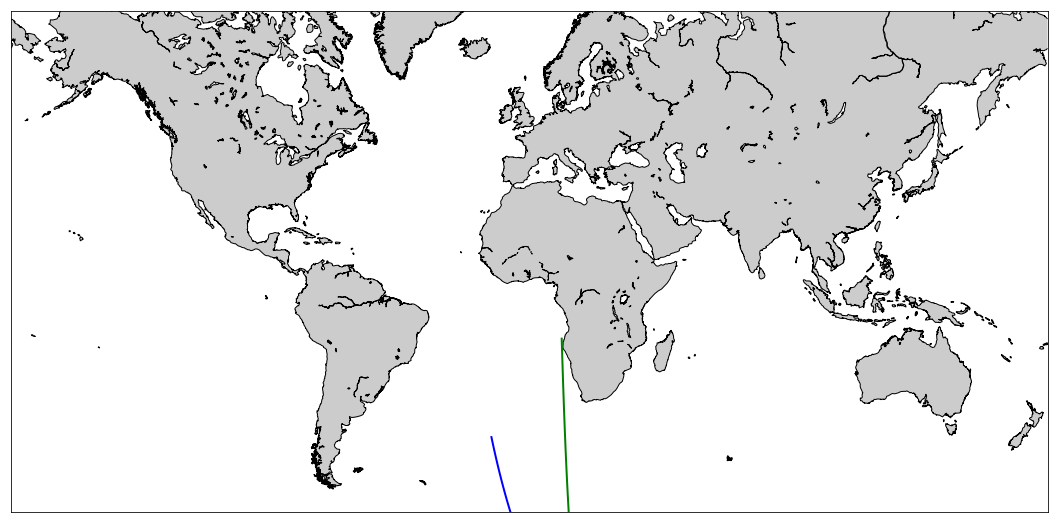

In [403]:
plotter(1)

(array([57, 58, 59, 60], dtype=int64),)


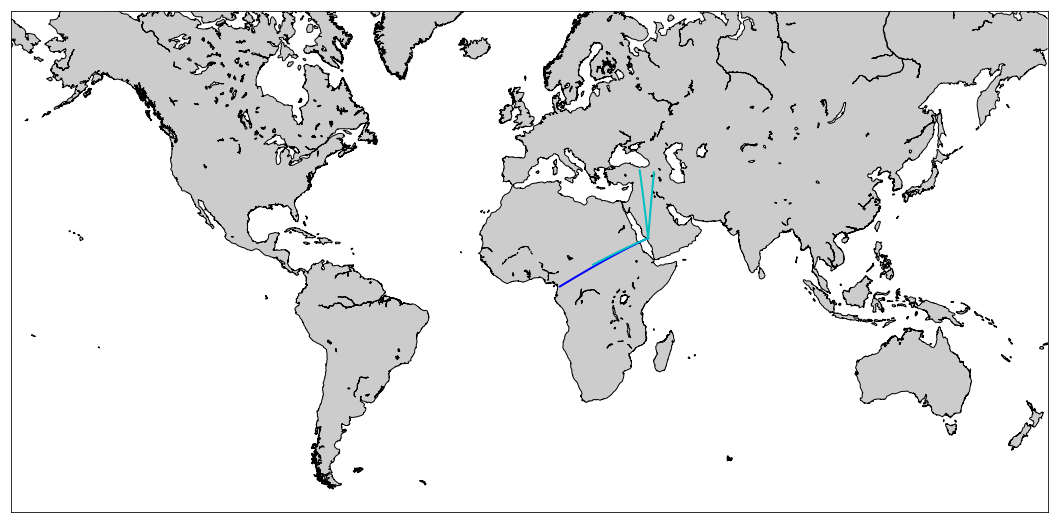

In [396]:
plotter(10)

(array([0, 1], dtype=int64),)


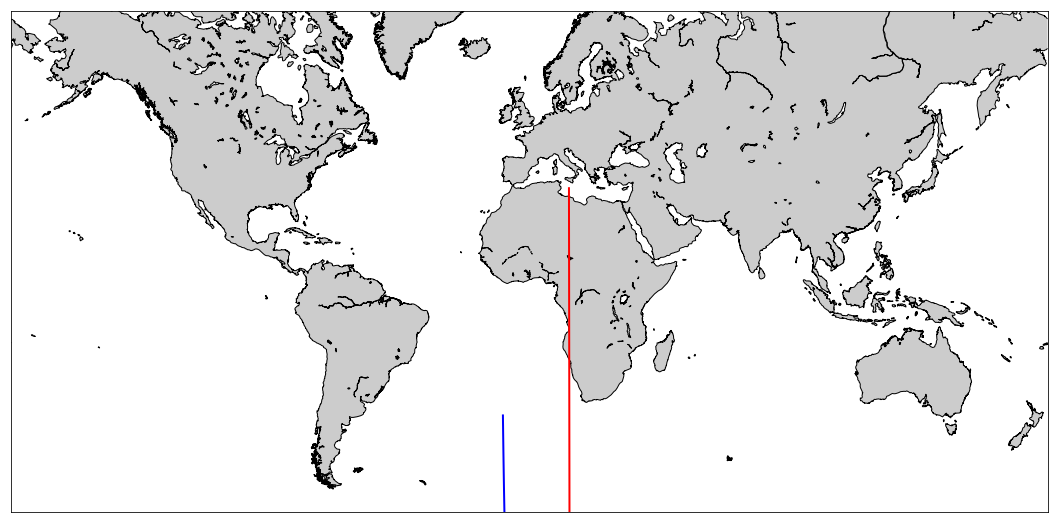

In [397]:
plotter(0)

(array([10, 11, 12, 13, 14, 15], dtype=int64),)


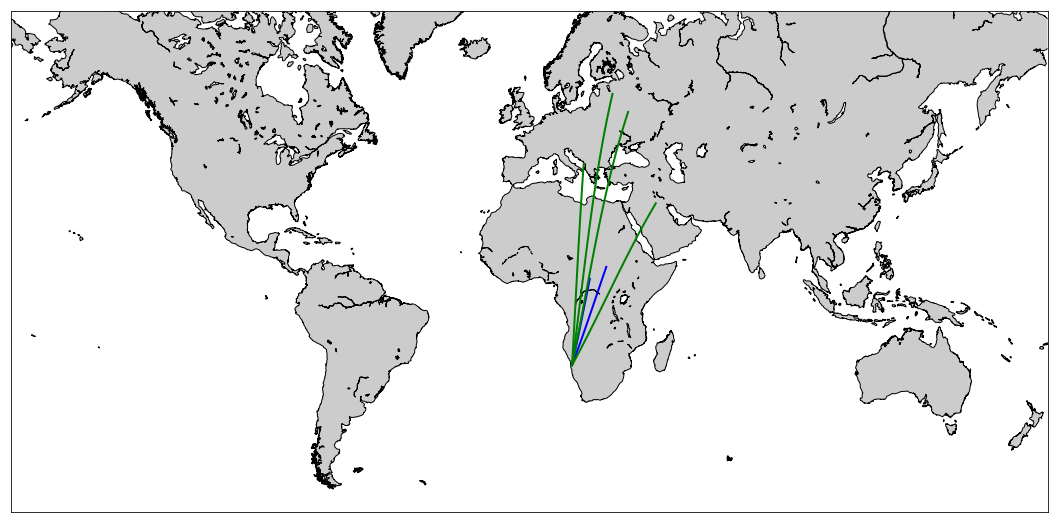

In [398]:
plotter(3)

(array([109, 110, 111, 112], dtype=int64),)


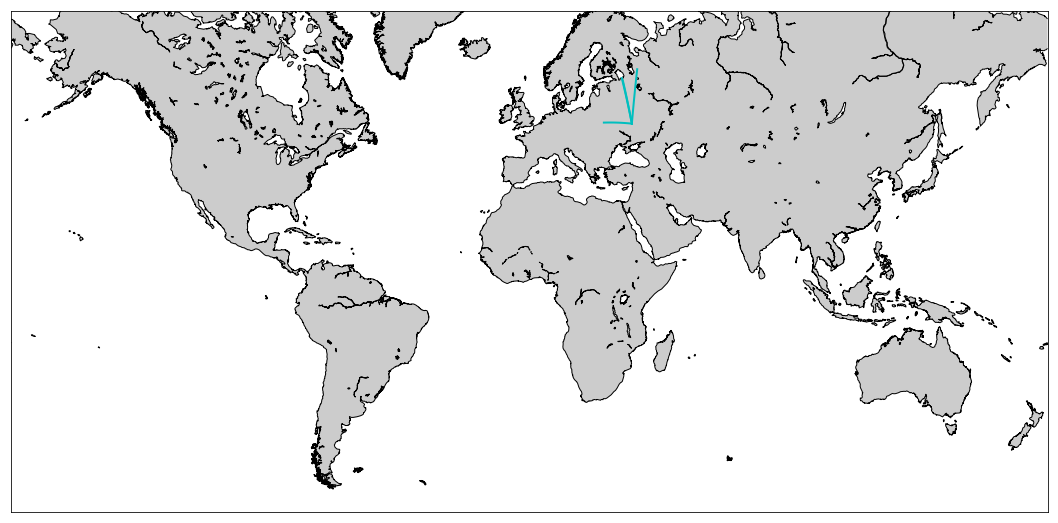

In [399]:
plotter(20)

(array([113, 114, 115, 116, 117, 118], dtype=int64),)


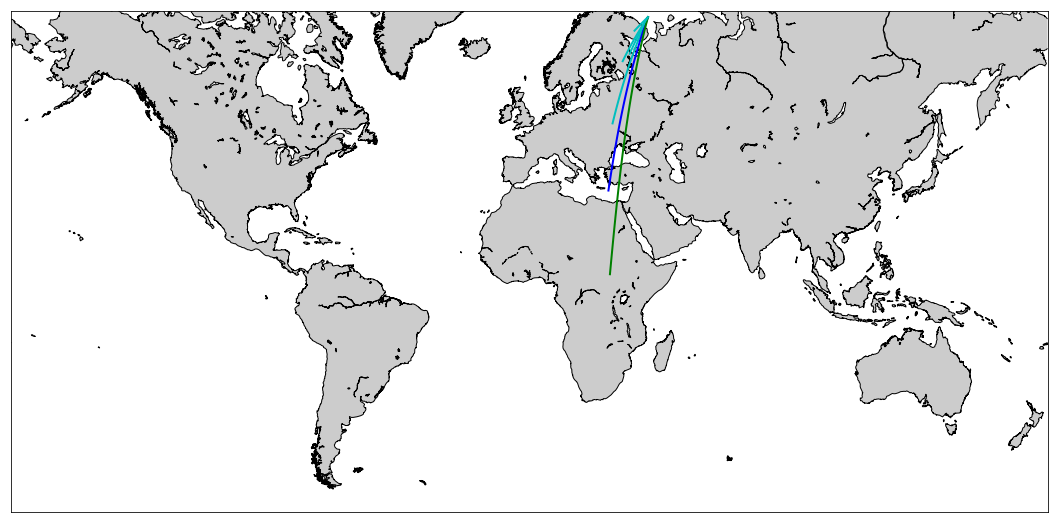

In [400]:
plotter(21)

In [401]:
plotter(29)

(array([148, 149, 150, 151], dtype=int64),)


ValueError: undefined inverse geodesic (may be an antipodal point)

## Seconde partie : utilisation du heatmap avec Kullback-Leibler

In [7]:
#création des données
heatmap = np.loadtxt('heatmap.txt')
my_data = genfromtxt('default_plus_chromatic_features_1059_tracks.txt', delimiter=',')
my_data = my_data[0:len(my_data), 0:72]
my_data = np.concatenate((my_data, heatmap), 1)
train = my_data[0:799,]
test = my_data[800:,]


### Changements de fonctions

In [37]:
init_scale = 0.1
weight_prior_variance = 10.0
init_params = init_random_params(init_scale, layer_sizes=[72, 500, 400])


#Fonction de prédiction directement inspirée de l'exemple
#différence par rapport à avant : on fait en sorte que les outputs soient bien compris entre 0 et 1 et somment à 1
def nn_predict(params, inputs, nonlinearity = np.tanh):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlinearity(outputs)
    outputs =( np.tanh(outputs)+1)/2
    outputs = outputs/np.sum(outputs)
    return outputs

# Divergence de Kullback-Leibler : on ajoute un epsilon aux histogrammes pour éviter les divisions par 0
def kullback_leibler(predict, true) : 
    predict = predict +0.00000001
    predict = predict/sum(predict)
    true = true+0.00000001
    true = true/sum(true)
    return(-np.sum(predict*np.log(true/predict)))

#fonction objectif : calcule KL entre la prédiction et la vraie valeur à l'itération t
def kullback_leibler_objective(params, t) : 
    predict = nn_predict(params, train[:,0:72] , nonlinearity=np.tanh)
    true = train[:,72:]
    KL = 0
    for i in range(np.shape(true)[0]) : 
        KL = KL +kullback_leibler(predict[i] , true[i] )
    return(KL)



### Résultats

In [41]:
#Optimisation

optimized_params = adam(grad(kullback_leibler_objective), init_params, step_size=0.01, num_iters=20000)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:88: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


In [42]:
def kullback_leibler_loss (params) : 
    preds = pred(params)
    true = []
    for i in range(np.shape(test)[0]) : 
         true.append(test[i, 72:])
    KL = []
    for i in range(np.shape(test)[0]):
        KL.append(kullback_leibler(preds[i] , true[i]))
    return(KL)

print(np.mean(np.array(kullback_leibler_loss(optimized_params))-np.array(kullback_leibler_loss(init_params))))

-1.65301144929


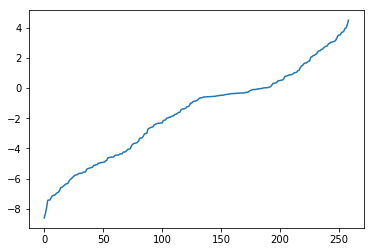

In [49]:
plt.plot(np.sort(np.array(kullback_leibler_loss(optimized_params))-np.array(kullback_leibler_loss(init_params))))
plt.show()

## Troisième partie : utilisation du Heatmap avec earth mover distance

### "Codage" du earth mover distance

In [72]:
#Copier-collé de l'approximation sinkhorn donnée dans le projet


# -*- coding: utf-8 -*-
"""
Dimension reduction with optimal transport
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

from scipy import linalg
import autograd.numpy as np
from pymanopt.manifolds import Stiefel
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent, TrustRegions


def dist(x1, x2):
    """ Compute squared euclidean distance between samples (autograd)
    """
    x1p2 = np.sum(np.square(x1), 1)
    x2p2 = np.sum(np.square(x2), 1)
    return x1p2.reshape((-1, 1)) + x2p2.reshape((1, -1)) - 2 * np.dot(x1, x2.T)



def sinkhorn(w1, w2, M, reg, k):
    """Sinkhorn algorithm with fixed number of iteration (autograd)
    """
    K = np.exp(-M / reg)
    ui = np.ones((M.shape[0],))
    vi = np.ones((M.shape[1],))
    for i in range(k):
        vi = w2 / (np.dot(K.T, ui))
        ui = w1 / (np.dot(K, vi))
    G = ui.reshape((M.shape[0], 1)) * K * vi.reshape((1, M.shape[1]))
    return G



def split_classes(X, y):
    """split samples in X by classes in y
    """
    lstsclass = np.unique(y)
    return [X[y == i, :].astype(np.float32) for i in lstsclass]



def fda(X, y, p=2, reg=1e-16):
    """
    Fisher Discriminant Analysis


    Parameters
    ----------
    X : numpy.ndarray (n,d)
        Training samples
    y : np.ndarray (n,)
        labels for training samples
    p : int, optional
        size of dimensionnality reduction
    reg : float, optional
        Regularization term >0 (ridge regularization)


    Returns
    -------
    P : (d x p) ndarray
        Optimal transportation matrix for the given parameters
    proj : fun
        projection function including mean centering


    """

    mx = np.mean(X)
    X -= mx.reshape((1, -1))

    # data split between classes
    d = X.shape[1]
    xc = split_classes(X, y)
    nc = len(xc)

    p = min(nc - 1, p)

    Cw = 0
    for x in xc:
        Cw += np.cov(x, rowvar=False)
    Cw /= nc

    mxc = np.zeros((d, nc))

    for i in range(nc):
        mxc[:, i] = np.mean(xc[i])

    mx0 = np.mean(mxc, 1)
    Cb = 0
    for i in range(nc):
        Cb += (mxc[:, i] - mx0).reshape((-1, 1)) * \
            (mxc[:, i] - mx0).reshape((1, -1))

    w, V = linalg.eig(Cb, Cw + reg * np.eye(d))

    idx = np.argsort(w.real)

    Popt = V[:, idx[-p:]]

    def proj(X):
        return (X - mx.reshape((1, -1))).dot(Popt)

    return Popt, proj



def wda(X, y, p=2, reg=1, k=10, solver=None, maxiter=100, verbose=0, P0=None):
    """
    Wasserstein Discriminant Analysis [11]_

    The function solves the following optimization problem:

    .. math::
        P = \\text{arg}\min_P \\frac{\\sum_i W(PX^i,PX^i)}{\\sum_{i,j\\neq i} W(PX^i,PX^j)}

    where :

    - :math:`P` is a linear projection operator in the Stiefel(p,d) manifold
    - :math:`W` is entropic regularized Wasserstein distances
    - :math:`X^i` are samples in the dataset corresponding to class i

    Parameters
    ----------
    X : numpy.ndarray (n,d)
        Training samples
    y : np.ndarray (n,)
        labels for training samples
    p : int, optional
        size of dimensionnality reduction
    reg : float, optional
        Regularization term >0 (entropic regularization)
    solver : str, optional
        None for steepest decsent or 'TrustRegions' for trust regions algorithm
        else shoudl be a pymanopt.solvers
    P0 : numpy.ndarray (d,p)
        Initial starting point for projection
    verbose : int, optional
        Print information along iterations



    Returns
    -------
    P : (d x p) ndarray
        Optimal transportation matrix for the given parameters
    proj : fun
        projection function including mean centering


    References
    ----------

    .. [11] Flamary, R., Cuturi, M., Courty, N., & Rakotomamonjy, A. (2016). Wasserstein Discriminant Analysis. arXiv preprint arXiv:1608.08063.

    """  # noqa

    mx = np.mean(X)
    X -= mx.reshape((1, -1))

    # data split between classes
    d = X.shape[1]
    xc = split_classes(X, y)
    # compute uniform weighs
    wc = [np.ones((x.shape[0]), dtype=np.float32) / x.shape[0] for x in xc]

    def cost(P):
        # wda loss
        loss_b = 0
        loss_w = 0

        for i, xi in enumerate(xc):
            xi = np.dot(xi, P)
            for j, xj in enumerate(xc[i:]):
                xj = np.dot(xj, P)
                M = dist(xi, xj)
                G = sinkhorn(wc[i], wc[j + i], M, reg, k)
                if j == 0:
                    loss_w += np.sum(G * M)
                else:
                    loss_b += np.sum(G * M)

        # loss inversed because minimization
        return loss_w / loss_b

    # declare manifold and problem
    manifold = Stiefel(d, p)
    problem = Problem(manifold=manifold, cost=cost)

    # declare solver and solve
    if solver is None:
        solver = SteepestDescent(maxiter=maxiter, logverbosity=verbose)
    elif solver in ['tr', 'TrustRegions']:
        solver = TrustRegions(maxiter=maxiter, logverbosity=verbose)

    Popt = solver.solve(problem, x=P0)

    def proj(X):
        return (X - mx.reshape((1, -1))).dot(Popt)

    return Popt, proj

In [91]:
#Perte earth mover approximée
#On utilise comme coûts une matrice de 1 avec la diagonale à 0

def earth_mover_objective (params,t) : 
    t = t%799
    predict = nn_predict(params, train[t,0:72] , nonlinearity=np.tanh)
    true = train[t,72:]/sum(train[t,72:])
    M= np.ones((400, 400))-np.identity(400)
    return(np.sum(np.multiply(M,sinkhorn(true, predict, M, 0.05, 1000))))


### Résultats

In [103]:
optimized_params = adam(grad(earth_mover_objective), init_params, step_size=0.01, num_iters=25000)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:88: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


In [106]:
def earth_mover_loss (params) : 
    preds = pred(params)
    true = []
    for i in range(np.shape(test)[0]) : 
         true.append(test[i, 72:])
    EM = []
    M= np.ones((400, 400))-np.identity(400)
    for i in range(np.shape(test)[0]):
        EM.append(np.sum(np.multiply(sinkhorn( true[i], preds[i], M, 0.05, 1000), M)))
    return(EM)


KeyboardInterrupt: 

In [ ]:
print(np.mean(np.array(earth_mover_loss(optimized_params))))
print(np.mean(np.array(earth_mover_loss(optimized_params))-np.array(earth_mover_loss(init_params))))

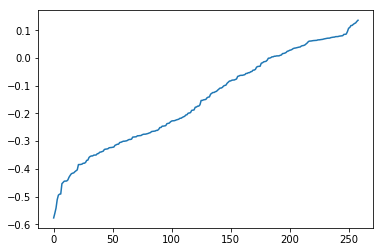

In [105]:
plt.plot(np.sort(np.array(earth_mover_loss(optimized_params))-np.array(earth_mover_loss(init_params))))
plt.show()